In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# mappingBLS State_FIPS with OEWS PRIM_STATE
fips_map = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', 
    '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', 
    '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', 
    '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
    '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', 
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', 
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', 
    '55': 'WI', '56': 'WY', '72': 'PR'  
}
abbr_to_fips = {v: k for k, v in fips_map.items()}


In [ ]:
print("Loading datasets...")
df_bls_state = pd.read_parquet('../data_bls/bls_labor_force_state_level_2015_2023.parquet')
df_oews = pd.read_csv('../data_bls/oews_data_2015_2023_cleaned.csv', dtype={'State_FIPS': str})


df_bls_state['Year'] = df_bls_state['Year'].astype(int)
df_oews['Year'] = df_oews['Year'].astype(int)

df_bls_state['State_FIPS'] = df_bls_state['State_FIPS'].astype(str)
df_oews['State_FIPS'] = df_oews['State_FIPS'].astype(str)

# join with Year and State_FIPS 
df_integrated = pd.merge(
    df_bls_state, 
    df_oews, 
    on=['Year', 'State_FIPS'], 
    how='inner'
)
df_integrated = df_integrated[df_integrated['OCC_CODE'] != '00-0000'].copy()

df_integrated.drop(columns=['AREA', 'AREA_TITLE', 'NAICS', 'NAICS_TITLE'], inplace=True, errors='ignore')

print("\n--- Integrated BLS and OEWS Data Information ---")
print(f"Total integrated records: {len(df_integrated)}")
df_integrated.info()
print("\nIntegrated Data Sample (First 5 rows):")
print(df_integrated.head().to_markdown(index=False))


Loading datasets...

--- Integrated BLS and OEWS Data Information ---
Total integrated records: 312596
<class 'pandas.core.frame.DataFrame'>
Index: 312596 entries, 1 to 313035
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Year                     312596 non-null  int64  
 1   State_FIPS               312596 non-null  object 
 2   Total_Labor_Force        312596 non-null  Int64  
 3   Total_Employed           312596 non-null  Int64  
 4   Total_Unemployed         312596 non-null  Int64  
 5   State_Unemployment_Rate  312596 non-null  Float64
 6   OCC_CODE                 312596 non-null  object 
 7   OCC_TITLE                312596 non-null  object 
 8   TOT_EMP                  301525 non-null  float64
 9   A_MEAN                   307029 non-null  float64
 10  A_MEDIAN                 304189 non-null  float64
 11  A_PCT10                  307059 non-null  float64
 12  A_PCT90         

In [3]:
print("\n--- Correlation Analysis ---")

correlation_data = df_integrated[['State_Unemployment_Rate', 'A_MEDIAN', 'A_MEAN', 'Total_Labor_Force']].copy()

correlation_data.dropna(inplace=True)

pearson_corr = correlation_data[['State_Unemployment_Rate', 'A_MEDIAN']].corr(method='pearson').iloc[0, 1]
print(f"Pearson Correlation (Unemployment Rate vs. Median Wage): {pearson_corr:.4f}")

spearman_corr = correlation_data[['State_Unemployment_Rate', 'A_MEDIAN']].corr(method='spearman').iloc[0, 1]
print(f"Spearman Correlation (Unemployment Rate vs. Median Wage): {spearman_corr:.4f}")



--- Correlation Analysis ---
Pearson Correlation (Unemployment Rate vs. Median Wage): -0.0248
Spearman Correlation (Unemployment Rate vs. Median Wage): -0.0396


The initial correlation analysis between the Annual Median Wage (A_MEDIAN), aggregated across all occupations, and the State Unemployment Rate (%) reveals a very weak, almost negligible negative relationship.

- Pearson Correlation (Linear): r = −0.0248

- Spearman Correlation (Monotonic): ρ = −0.0396

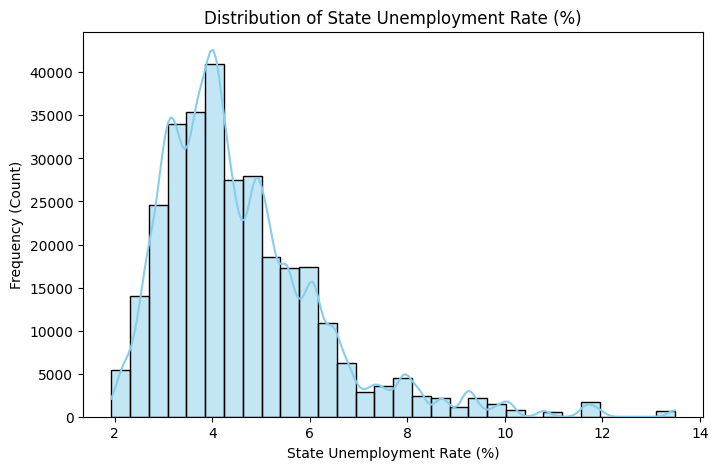

In [7]:
# --- plot: Distribution of State Unemployment Rate ---
plt.figure(figsize=(8, 5))
sns.histplot(correlation_data['State_Unemployment_Rate'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of State Unemployment Rate (%)')
plt.xlabel('State Unemployment Rate (%)')
plt.ylabel('Frequency (Count)')
plt.show()


The State Unemployment Rate distribution is right-skewed, peaking heavily between 3% and 6%. This suggests that the majority of state-year observations fall within a narrow band of low to moderate unemployment, while extreme high rates (above 10%) are relatively rare.

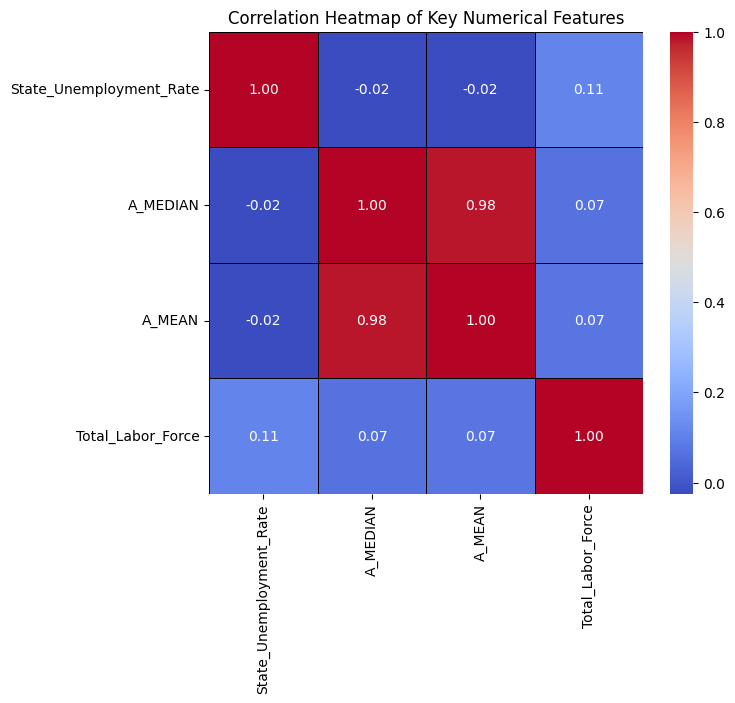

In [8]:

# --- plot:heatmap---
plt.figure(figsize=(7, 6))
corr_matrix = correlation_data.corr(numeric_only=True)
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True,
    linewidths=.5,
    linecolor='black'
)
plt.title('Correlation Heatmap of Key Numerical Features')
plt.show()

The heatmap shows weak linear relationship between the State Unemployment Rate and both Median Wage (A_MEDIAN) and Mean Wage (A_MEAN) (both Pearson ∣r∣≈0.02). This reinforces the need to use non-linear models and integrate socio-economic factors (PUMS) to explain the variations in unemployment.

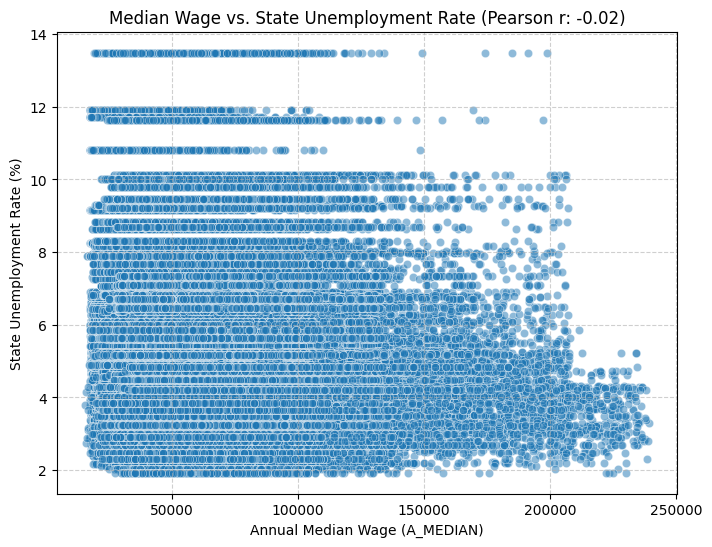

In [5]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x='A_MEDIAN', y='State_Unemployment_Rate', data=correlation_data, alpha=0.5)
plt.title(f'Median Wage vs. State Unemployment Rate (Pearson r: {pearson_corr:.2f})')
plt.xlabel('Annual Median Wage (A_MEDIAN)')
plt.ylabel('State Unemployment Rate (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() 



--- Visualization 3: Wage Distribution by Major Occupation ---


/var/folders/jl/rljwzvf15d1d_1st52w28dcc0000gn/T/ipykernel_44393/176659132.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


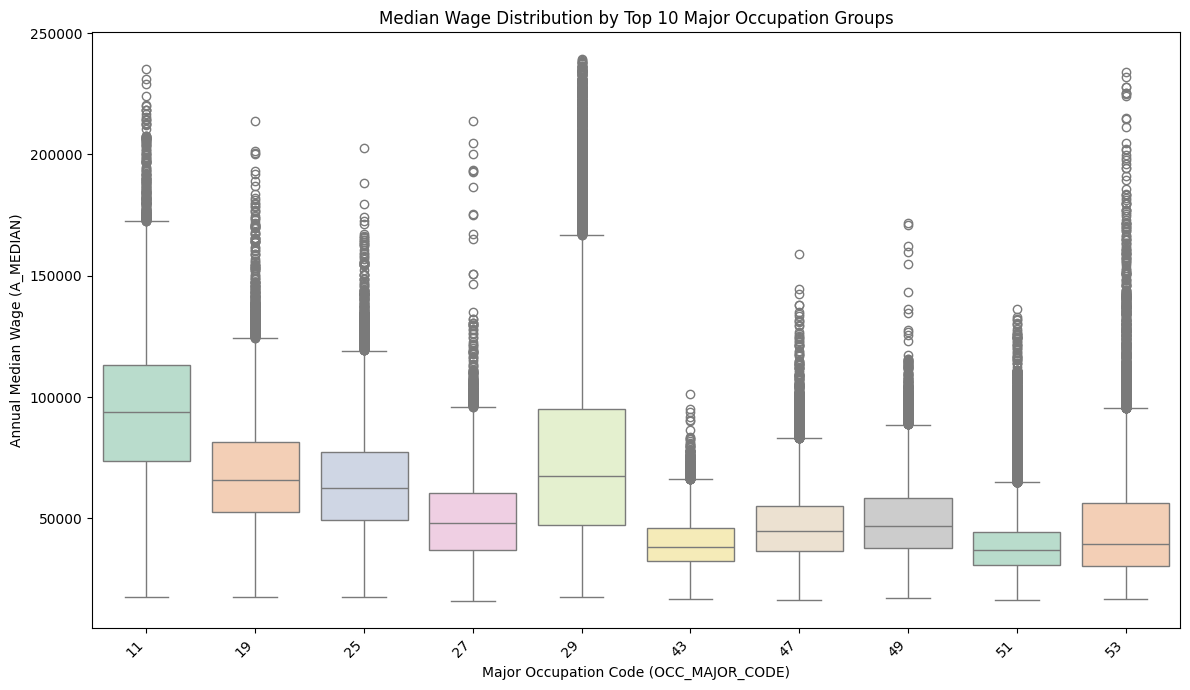

In [6]:
print("\n--- Visualization 3: Wage Distribution by Major Occupation ---")

# 筛选出主要职业（OCC_CODE只包含两位数字，即大类）
# 使用正则表达式筛选出 'XX-XXXX' 格式中 XX-XXXX 的大类代码，
# 这里简化为只看前两个字符
df_major_occ = df_integrated[df_integrated['OCC_CODE'].str.match(r'^\d\d-\d{4}')].copy()
df_major_occ['OCC_MAJOR_CODE'] = df_major_occ['OCC_CODE'].str[:2]

# 排除OCC_CODE为 '00-0000' 的总计行，上面已经排除了
# 统计每大类职业的记录数，并选取 Top 10
top_10_codes = df_major_occ['OCC_MAJOR_CODE'].value_counts().nlargest(10).index
df_top_occ = df_major_occ[df_major_occ['OCC_MAJOR_CODE'].isin(top_10_codes)]

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='OCC_MAJOR_CODE', 
    y='A_MEDIAN', 
    data=df_top_occ, 
    palette="Pastel2"
)
plt.title('Median Wage Distribution by Top 10 Major Occupation Groups')
plt.xlabel('Major Occupation Code (OCC_MAJOR_CODE)')
plt.ylabel('Annual Median Wage (A_MEDIAN)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:

output_parquet_path = 'data/integrated_bls_oews_state_year_occ.parquet'
df_integrated.to_parquet(output_parquet_path, index=False, compression='snappy')
print(f"\nSuccessfully saved integrated data for next stage modeling to: {output_parquet_path}")

There is significant wage disparity across the major occupation groups. For instance, Occupation Code '11' (typically Management) exhibits a much higher median wage and broader interquartile range (IQR) compared to codes like '43' (Office and Administrative Support), indicating that occupational category is a major driver of wage variability.

## Key Observations

- Direction is Expected: The negative sign indicates that states with a higher median wage tend to have a slightly lower unemployment rate, which is the economically expected direction.

- Magnitude is Weak: The coefficient values (close to 0) suggest that state-level median wage, by itself, is a poor linear predictor of the state unemployment rate when considering all occupations and all years (2015-2023) together. The scatter plot confirms this, showing a dense, largely unclustered cloud of data points.

- Justification for Big Data Analysis: This weak correlation is reasonable because aggregating wages across all occupations and all states masks the granular relationships that exist within specific high-skill sectors or different educational levels. The finding justifies the project's core hypothesis: that the true disparities in the labor market are linked to socio-economic factors like education levels and income distribution, which can only be uncovered using the massive, integrated datasets (BLS + OEWS + ACS PUMS) and distributed computing technologies like Spark and Dask. The next step should be to use the integrated data for predictive modeling to estimate unemployment trends.